
   ###  2D Stochastic Gaussian Simulation in Python for Engineers and Geoscientists 

### with GSLIB's SGSIM Program Converted to Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Sequential Gaussian Simulation in Python with GSLIB's SGSIM program translated to Python from the original FORTRAN GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

### PGE 383 Exercise: Methods for Spatial Simulation with GeostatsPy

Here's a simple workflow for spatial simulation with SGSIM. This method is ciritical for:

* Building spatial models that honor the univariate and spatial distribution of the property of interest 

First let's explain the concept of spatial simulation.

#### Spatial Simulation

We can define and contrast estimation and simulation.

* Estimation: 
    * a method to calculate the best estimate at each location focus on local accuracy, globally too smooth

* Simulation: 
    * a method to calculate a good / reasonable estimate at each location focus on global accuracy, sacrifice local accuracy

What is wrong with kriging?

Kriging is locally accurate and smooth, appropriate for visualizing trends, inappropriate for any applications where heterogeneity is important 

The ''variance'' of the kriged estimates is too small: 

\begin{equation}
Var\{Y^*(\bf{u})\} = \sigma^2 - \sigma^2_{SK}(\bf{u})
\end{equation}

$\sigma^2$ is variance of the property, $𝑉𝑎𝑟{𝑌^∗(\bf{𝐮})}$ is the variance of the estimates 

Consider the following:

* $\sigma^2_{SK}(\bf{u})$ is zero at the data locations → no smoothing 

* $\sigma^2_{SK}(\bf{u})$ is the variance $\sigma^2$ beyond range of data locations, this is complete smoothing 

* spatial variations of $\sigma^2_{SK}(\bf{u})$ depend on the variogram and data spacing 

Missing variance in the estimates, $Var\{Y^*(\bf{u})\}$, is the kriging variance, Monte Carlo Simulation corrects the variance (get right histogram)

* we will add a random residual, $Y_s(\bf{u}) = Y^*(\bf{u}) + R(\bf{u})$, where $R(\bf{u})$ is the random residual that adds back in the missing variance

and correct the covariance (get the right variogram) 

* sequential simulation – add simulated values to data to enforce the correct covariance between estimates

Simulation reproduces histogram, honors spatial variability (variogram); therefore, it is appropriate for process evaluation where heterogeneity is important 

Also, the simulation approach allows an assessment of uncertainty with alternative realizations 

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_MV_biased.csv available at https://git.io/fhgu0.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.

In [3]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import math

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Load the Required Libraries

The following code loads the required libraries.

In [4]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [5]:
os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [6]:
df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df['logPerm'] = np.log(df['Perm'].values)
df.head()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
0,331,523,280.0,799.0,1.0,0.161938,395.717857,4212.827564,5.980701
1,206,339,680.0,859.0,1.0,0.139132,15.031775,4684.316559,2.710166
2,291,458,420.0,959.0,1.0,0.137036,46.273841,4460.227665,3.834577
3,285,452,860.0,889.0,1.0,0.116910,1.446133,3931.954570,0.368893
4,95,156,540.0,799.0,1.0,0.126067,24.399946,4906.490088,3.194581


#### Sequential Gaussian Simulation

Let's jump right to building multiple realizations with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1282
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.014 (close to 0.0?)
                                   variance = 0.9813 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
         

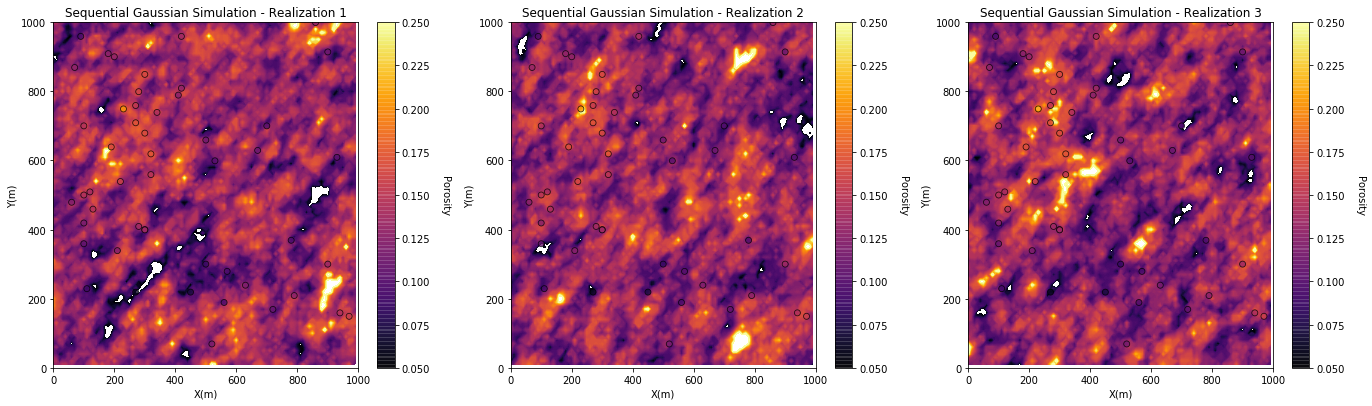

In [10]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 400; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=100,hmin1=60)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
            zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(131)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(132)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(133)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Now we have 3 equiprobable realizations for porosity over the area of interest.  See the difference?  Away from the data at the range the full range of porosity values is possible!  Let's check the realizations.

#### Realization Checking

All of the theory of sequential Gaussian simulation supports the calculation of realizations that honor the input statistics.  Let' confirm that by checking the:

* histograms
* variogram


In [11]:
np.linspace(0.0,0.4,20)

array([0.        , 0.02105263, 0.04210526, 0.06315789, 0.08421053,
       0.10526316, 0.12631579, 0.14736842, 0.16842105, 0.18947368,
       0.21052632, 0.23157895, 0.25263158, 0.27368421, 0.29473684,
       0.31578947, 0.33684211, 0.35789474, 0.37894737, 0.4       ])

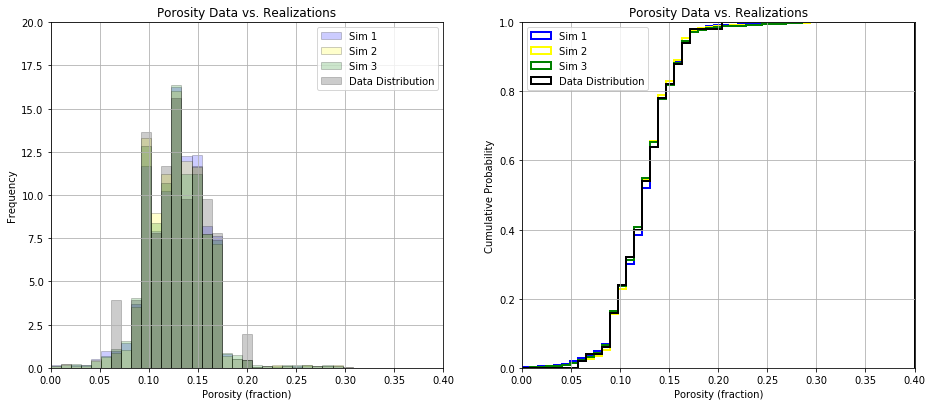

In [16]:
# Check the histograms
plt.subplot(121)
plt.hist(sim.flatten(), facecolor='blue',bins=np.linspace(0.0,0.4,40),alpha=0.2,density=True,edgecolor='black',label = 'Sim 1')
plt.hist(sim2.flatten(), facecolor='yellow',bins=np.linspace(0.0,0.4,40),alpha=0.2,density=True,edgecolor='black',label = 'Sim 2')
plt.hist(sim3.flatten(), facecolor='green',bins=np.linspace(0.0,0.4,40),alpha=0.2,density=True,edgecolor='black',label = 'Sim 3')
plt.hist(df['Porosity'].values, facecolor='black',bins=np.linspace(0.0,0.4,40),alpha=0.2,density=True,edgecolor='black',label = 'Data Distribution')
plt.xlim([0.0,0.4]); plt.ylim([0,20.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Data vs. Realizations')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(122)
plt.hist(sim.flatten(), color='red',lw = 2, bins=np.linspace(0.0,0.4,50),histtype="step",alpha=1.0,density=True,cumulative=True,edgecolor='blue',label='Sim 1')
plt.hist(sim2.flatten(), color='blue',lw = 2, bins=np.linspace(0.0,0.4,50),histtype="step",alpha=1.0,density=True,cumulative=True,edgecolor='yellow',label='Sim 2')
plt.hist(sim3.flatten(), color='green',lw = 2, bins=np.linspace(0.0,0.4,50),histtype="step",alpha=1.0,density=True,cumulative=True,edgecolor='green',label='Sim 3')
plt.hist(df['Porosity'].values, color='black',lw = 2,bins=np.linspace(0.0,0.4,50),histtype="step",alpha=1.0,density=True,cumulative=True,edgecolor='black',label='Data Distribution')
plt.xlim([0.0,0.4]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Cumulative Probability'); plt.title('Porosity Data vs. Realizations')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

The histograms look quite good.  The three realizations have 

Let's look at 4 realizations of porosity all with short range isotropic variograms.

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


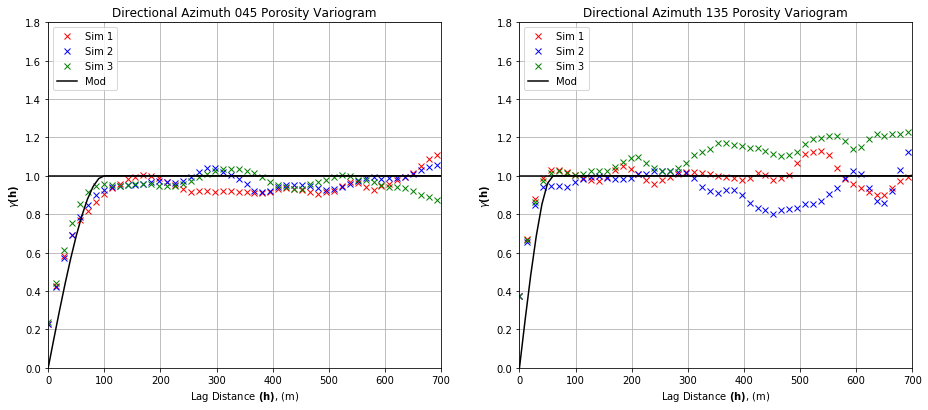

In [14]:
lag045sim1, vario045sim1, npar045 = geostats.gam(sim,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = 80, isill = 1.0)
lag045sim2, vario045sim2, npar045 = geostats.gam(sim2,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = 80, isill = 1.0)
lag045sim3, vario045sim3, npar045 = geostats.gam(sim3,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = 80, isill = 1.0)

index,lag045mod,vario045mod,cov,ro  = geostats.vmodel(nlag = 80, xlag = 10.0, azm = 45.0, vario = vario)

lag135sim1, vario135sim1, npar045 = geostats.gam(sim,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = 1, nlag = 80, isill = 1.0)
lag135sim2, vario135sim2, npar045 = geostats.gam(sim2,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = 1, nlag = 80, isill = 1.0)
lag135sim3, vario135sim3, npar045 = geostats.gam(sim3,tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = 1, nlag = 80, isill = 1.0)

index,lag135mod,vario135mod,cov,ro  = geostats.vmodel(nlag = 80, xlag = 10.0, azm = 135.0, vario = vario)

plt.subplot(121)
plt.plot(lag045sim1,vario045sim1,'x',color = 'red',label = 'Sim 1')
plt.plot(lag045sim2,vario045sim2,'x',color = 'blue',label = 'Sim 2')
plt.plot(lag045sim3,vario045sim3,'x',color = 'green',label = 'Sim 3')
plt.plot(lag045mod,vario045mod,'-',color = 'black',label = 'Mod')

plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Azimuth 045 Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)
plt.plot(lag135sim1,vario135sim1,'x',color = 'red',label = 'Sim 1')
plt.plot(lag135sim2,vario135sim2,'x',color = 'blue',label = 'Sim 2')
plt.plot(lag135sim3,vario135sim3,'x',color = 'green',label = 'Sim 3')
plt.plot(lag135mod,vario135mod,'-',color = 'black',label = 'Mod')

plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Azimuth 135 Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

#### Minimum Acceptance Checks

We will make more realizations and dmeonstrate the approach of minimum acceptance checks.  

With this approach we should check:

* the simulated values at the data locations
* the histograms of the simulated realizations
* the spatial continuity of the simulated realizations

We will skip the the first check as with our 'simple' workflow the data are directly assigned to the model cells.

You can specify how many realizations as 'nreal' below.

In [25]:
nreal = 20

nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 400; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=100,hmin1=60)
tmin = -999; tmax = 999

realizations = np.zeros((nreal,ny,nx))
for ireal in range(0,nreal):
    realizations[ireal] = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
            zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073+ireal,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)



 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1246
                 Weighted Variance             = 0.0007
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0111 (close to 0.0?)
                                   variance = 0.9696 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.019 (close to 0.0?)
                                   variance = 1.051 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1246
                 Weighted Variance             = 0.0007
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curren

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0297 (close to 0.0?)
                                   variance = 0.9704 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1246
                 Weighted Variance             = 0.0007
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

Now let's check all of the distributions.

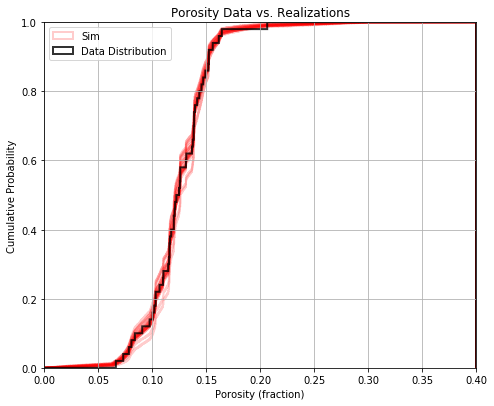

In [31]:
plt.subplot(111)
for ireal in range(0,nreal):
    if ireal == 0:
        plt.hist(realizations[ireal].flatten(), color='red',lw = 2, bins=np.linspace(0.0,0.4,1000),histtype="step",alpha=0.2,density=True,cumulative=True,edgecolor='red',label='Sim')
    else:
        plt.hist(realizations[ireal].flatten(), color='red',lw = 2, bins=np.linspace(0.0,0.4,1000),histtype="step",alpha=0.2,density=True,cumulative=True,edgecolor='red')
        
plt.hist(df['Porosity'].values, color='black',lw = 2,bins=np.linspace(0.0,0.4,1000),histtype="step",alpha=0.8,density=True,cumulative=True,edgecolor='black',label='Data Distribution')
plt.xlim([0.0,0.4]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Cumulative Probability'); plt.title('Porosity Data vs. Realizations')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

Now let's check the experimental variograms vs. the input model of spatial continuity.

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


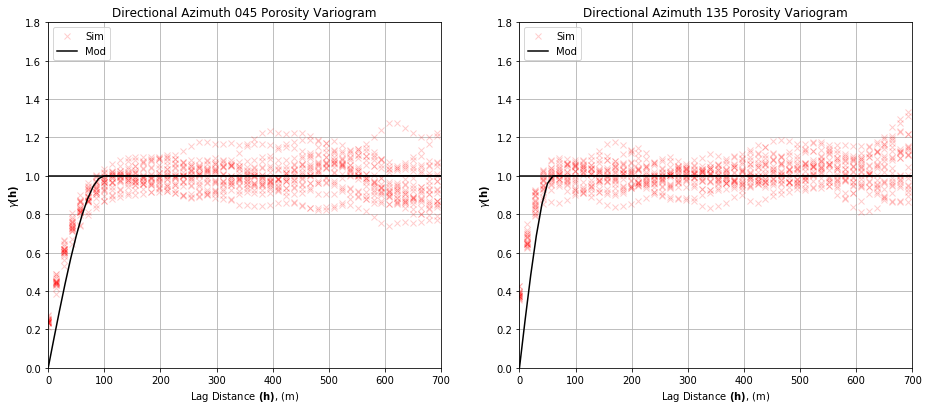

In [30]:
nlag = 80

lag045sim = np.zeros((nreal,nlag)); vario045sim = np.zeros((nreal,nlag)); npar045sim = np.zeros((nreal,nlag)); 
lag135sim = np.zeros((nreal,nlag)); vario135sim = np.zeros((nreal,nlag)); npar135sim = np.zeros((nreal,nlag));

for ireal in range(0,nreal):
    lag045sim[ireal], vario045sim[ireal], npar045sim[ireal] = geostats.gam(realizations[ireal],tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = nlag, isill = 1.0)
    lag135sim[ireal], vario135sim[ireal], npar135sim[ireal] = geostats.gam(realizations[ireal],tmin = -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = 1, nlag = nlag, isill = 1.0)

index,lag045mod,vario045mod,cov,ro  = geostats.vmodel(nlag = 80, xlag = 10.0, azm = 45.0, vario = vario)
index,lag135mod,vario135mod,cov,ro  = geostats.vmodel(nlag = 80, xlag = 10.0, azm = 135.0, vario = vario)

plt.subplot(121)
for ireal in range(0,nreal):
    if ireal == 0:
        plt.plot(lag045sim[ireal],vario045sim[ireal],'x',color = 'red',label = 'Sim', alpha = 0.2)
    else:
        plt.plot(lag045sim[ireal],vario045sim[ireal],'x',color = 'red', alpha = 0.2)
        
plt.plot(lag045mod,vario045mod,'-',color = 'black',label = 'Mod')

plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Azimuth 045 Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)
for ireal in range(0,nreal):
    if ireal == 0:
        plt.plot(lag135sim[ireal],vario135sim[ireal],'x',color = 'red',label = 'Sim',alpha = 0.2)
    else:
        plt.plot(lag135sim[ireal],vario135sim[ireal],'x',color = 'red',alpha = 0.2)
        
plt.plot(lag135mod,vario135mod,'-',color = 'black',label = 'Mod')

plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Azimuth 135 Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

The variogram reproduction looks good.  There are ergodic fluctuations, but the model is at the average for each lag distance.

#### Comments

This was a basic demonstration of spatial simulation. I know the simulation program is rough and the code needs some clean up, but we are getting to the point where we have a function package for Geostatistics in Python.  

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
